In [38]:
# ----------------- Load packages ------------------- #
import os
import numpy as np
import pandas as pd
import mne
from scipy.io import loadmat
from AutoPSG import *
from AutoPSG.artifact_detect import annotate_epoch_chan, load_hypnogram_data, good_epoch_dur, hypnogram_segment, badchan_var, zscoreamp_epoch_epochwise, zscoreamp_epoch_chanwise
from AutoPSG.artifact_detect import flat_epoch, ptpamp_epoch, threshold_badchan, threshold_badepoch, reject_bad_epoch, interpolate_by_epoch, apply_ica_to_segments

In [6]:
def load_raw(file_path):
    if file_path.endswith('.vhdr'):
        return mne.io.read_raw_brainvision(file_path, preload=True)
    elif file_path.endswith('.edf'):
        return mne.io.read_raw_edf(file_path, preload=True)
    elif file_path.endswith('.fif'):
        return mne.io.read_raw_fif(file_path, preload=True)
    elif file_path.endswith('.set'):
        return mne.io.read_raw_eeglab(file_path, preload=True)
    elif file_path.endswith('.mat'):
        return mne.io.read_raw_fieldtrip(file_path, preload=True)
    elif file_path.endswith('.bdf'):
        return mne.io.read_raw_bdf(file_path, preload=True)
    elif file_path.endswith('.cnt'):
        return mne.io.read_raw_cnt(file_path, preload=True)
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

In [160]:
def plot_bad_artifacts(raw, stages, interest_stage = None):
    """
    Plot a 2D visualization of bad channels, bad epochs, and bad segments,
    with a hypnogram showing sleep stages.

    Parameters:
        raw: mne.io.Raw
            Preprocessed raw EEG data.
        stages: list of tuples
            Sleep stages with their durations, e.g., [(stage_value, duration), ...].
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    from matplotlib.patches import Patch

    picks = [ch for ch, ch_type in zip(raw.ch_names, raw.get_channel_types()) if ch_type == 'eeg']

    if not picks:
        raise ValueError("No EEG channels found in the data.")

    data = np.zeros((len(picks), raw.n_times))

    for annot in raw.annotations:
        if annot['description'] == 'Bad_epoch':
            onset_idx = int(annot['onset'] * raw.info['sfreq'])
            offset_idx = int(onset_idx + annot['duration'] * raw.info['sfreq'])
            data[:, onset_idx:offset_idx] = 2  # Orange for bad epochs

    for annot in raw.annotations:
        if annot['description'] != 'Bad_epoch':
            onset_idx = int(annot['onset'] * raw.info['sfreq'])
            offset_idx = int(onset_idx + annot['duration'] * raw.info['sfreq'])
            ch_names = annot['ch_names'] if 'ch_names' in annot.keys() else []
            for chan_name in ch_names:
                if chan_name in picks:
                    chan_idx = picks.index(chan_name)
                    data[chan_idx, onset_idx:offset_idx] = 3  # Orange for bad segments

    bad_channels = raw.info['bads']
    for idx, ch in enumerate(picks):
        if ch in bad_channels:
            data[idx, :] = 1  # Red for bad channels

    artifact_durations = np.sum(data > 0, axis=1)
    top_channels_idx = np.argsort(artifact_durations)[-8:]  # Indices of top 8 channels

    artifact_colors = {0: "white", 1: "red", 2: "darkorange", 3: "red"}
    artifact_labels = {
        1: "Bad Channels and Segments Interpolated",
        2: "Bad Epochs Excluded"
    }

    cmap = ListedColormap([artifact_colors[key] for key in sorted(artifact_colors.keys())])

    time = np.linspace(0, raw.times[-1] / 60, raw.n_times)

    # Create the figure and subplots
    fig, (ax_hypnogram, ax_artifacts) = plt.subplots(
        2, 1, figsize=(8, 6.6), gridspec_kw={'height_ratios': [2, 8]}, sharex=True)

    # Plot the hypnogram
    stage_times = np.cumsum([duration for _, duration, *_ in stages])
    stage_values = [stage for stage, *_  in stages]
    stage_times = np.insert(stage_times, 0, 0)
    stage_values = np.insert(stage_values, len(stage_times) - 1, stage_values[0])

    stage_mapping = {"Wake": 0, "N1": 1, "N2": 2, "SWS": 3, "REM": 4}

    if interest_stage:
        interest_stage_idx = [stage_mapping[stage] for stage in interest_stage if stage in stage_mapping]
    else:
        interest_stage_idx = []

    for i in range(1, len(stage_times)):
        if stage_values[i - 1] in interest_stage_idx or stage_values[i] in interest_stage_idx:
            ax_hypnogram.step(stage_times[i - 1:i + 1] / 60, stage_values[i - 1:i + 1], where="post", color="red")
        else:
            ax_hypnogram.step(stage_times[i - 1:i + 1] / 60, stage_values[i - 1:i + 1], where="post", color="black")
    
    ax_hypnogram.set_ylabel("Stage")
    ax_hypnogram.set_ylim(-0.5, 4.5)
    ax_hypnogram.set_yticks(range(5))
    ax_hypnogram.set_yticklabels(["Wake", "N1", "N2", "SWS", "REM"])
    ax_hypnogram.grid(True, axis='y', linestyle='--', linewidth=0.5)

    # Plot the artifacts
    ax_artifacts.imshow(data, aspect='auto', interpolation='nearest', cmap=cmap, origin='lower',
                    extent=[time[0], time[-1], -0.5, len(picks) - 0.5], zorder=0)

    ax_artifacts.invert_yaxis()

    y_labels = [f"{picks[i]}" if i in top_channels_idx else "" for i in range(len(picks))]
    ax_artifacts.set_yticks(range(len(picks)))
    ax_artifacts.set_yticklabels(y_labels)

    # Highlight bad channels in red, other top channels in black
    for tick, label in zip(range(len(picks)), ax_artifacts.get_yticklabels()):
        if picks[tick] in bad_channels:
            label.set_color("red")
        elif tick in top_channels_idx:
            label.set_color("black")

    ax_artifacts.set_xlabel('Time (minutes)')
    ax_artifacts.set_ylabel('Channels')

    legend_patches = [
        Patch(color=artifact_colors[key], label=artifact_labels[key])
        for key in sorted(artifact_labels.keys())
    ]
    ax_artifacts.legend(handles=legend_patches, loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=len(legend_patches))

    plt.tight_layout()
    plt.show()

In [ ]:
add hypno

In [144]:
def auto_artifact_detect_interp(raw, stage, picks, reference, subject_id, epoch_length, epoch_slide = None, interest_stage = None):
    """
    Perform artifact rejection on EEG data, including bad channel handling,
    epoch-wise artifact detection, and interpolation.

    Parameters:
        raw: mne.io.Raw
            The raw EEG data.
        picks: list
            Channels to include in processing.
        reference: list or str
            Reference channel(s) used, if average keep empty.
        subject_id: int or str
            Identifier for the subject.
        epoch_length: float
            Length of each epoch in seconds.
        epoch_slide: float
            Slide duration for overlapping epochs in seconds.

    Returns:
        mne.io.Raw
            Preprocessed raw EEG data with artifacts rejected and interpolated.
    """
    # ---- Bad Channel Identification and Visualization ----
    raw_copy = badchan_var(raw, picks=picks, reference=reference)
    raw_copy.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True)

    # ---- Artifact Detection ----
    raw_copy = ptpamp_epoch(raw_copy, threshold=600e-6, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=reference)
    raw_copy = zscoreamp_epoch_epochwise(raw_copy, stage, threshold_z=5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=reference)
    raw_copy = zscoreamp_epoch_chanwise(raw_copy, threshold_z=5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference=reference)
    threshold_badepoch(raw_copy, picks=picks, percent_chan_bad=10)
    raw_copy.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True)
    plot_bad_artifacts(raw, stages = stage, interest_stage = interest_stage)

    # ---- Artifact Interpolation ----
    raw_copy = raw_copy.interpolate_bads(reset_bads=True, mode='accurate', origin='auto', method='spline', exclude=(), verbose='ERROR')
    raw_copy = interpolate_by_epoch(raw_copy, picks=picks, window_ratio=0.05)

    return raw_copy

In [19]:
def load_hypnogram_data(subject, file_path = None):
    if file_path is None:
        file_path = f'/Users/theang/Desktop/EMO_PSG_fMRI/data/scoring_file/{subject}.mat'
    scoring = loadmat(file_path)
    stages = scoring['stageData']['stages']
    stages = np.concatenate([np.concatenate(stage) for stage in stages])
    stages_df = pd.DataFrame(stages, columns=['stages'])
    stages[stages == 5] = '4'
    stages_df.iloc[-1] = 0
    stages_df['stages'] = stages_df['stages'].astype(int)
    
    return stages_df['stages'].values.flatten()

In [ ]:
def load_hypnogram_data(subject, file_path = None):
    if file_path is None:
        file_path = f'/Users/theang/Desktop/EMO_PSG_fMRI/data/scoring_file/{subject}.mat'
    scoring = loadmat(file_path)
    stages = scoring['stageData']['stages']
    stages = np.concatenate([np.concatenate(stage) for stage in stages])
    stages_df = pd.DataFrame(stages, columns=['stages'])
    stages[stages == 5] = '4'
    stages_df.iloc[-1] = 0
    stages_df['stages'] = stages_df['stages'].astype(int)
    
    return stages_df['stages'].values.flatten()

def good_epoch_dur(raw, seg_start, seg_end, seg_len):
    bad_dur = sum(max(0, min(anno['onset'] + anno['duration'], seg_end) - max(anno['onset'], seg_start)) 
                  for anno in raw.annotations if 'Bad_epoch' in anno['description'])
    
    return max(0, seg_len - bad_dur)

def hypnogram_segment(subject, raw, interval=30, bad_epoch = True, file_paths = None):
    hypno = load_hypnogram_data(subject, file_path = file_paths)
    ica_segments = []
    cur_stage, cnt, seg_start = hypno[0], 0, 0
    
    for stage in hypno:
        if stage == cur_stage:
            cnt += 1
        else:
            seg_len = cnt * interval
            seg_end = seg_start + seg_len
            valid_dur = good_epoch_dur(raw, seg_start, seg_end, seg_len)
            ica_segments.append((cur_stage, seg_len, valid_dur))
            cur_stage, cnt, seg_start = stage, 1, seg_end

        if bad_epoch:
            if stage == 6:
                onset = i * interval
                bad_epoch = mne.Annotations(
                    onset=onset,
                    duration=interval,
                    description='Bad_epoch',
                    orig_time=None
                )
                raw.set_annotations(bad_epoch)

    seg_len = cnt * interval
    seg_end = min(seg_start + seg_len, raw.times[-1])  # Ensure segment end is not later than raw_end_time
    seg_len = seg_end - seg_start  # Recalculate the segment length if needed
    valid_dur = good_epoch_dur(raw, seg_start, seg_end, seg_len)
    ica_segments.append((cur_stage, seg_len, valid_dur))

    return ica_segments

In [ ]:
def load_stim(raw):
    ## put in the processing step, not preprocessing
    # Load stimulation onsets
    if stim_file is not None:
        stim = load_stim(subject_id=id, raw=raw)
        annotate_stim(raw, stim)
    else:
        stim = None

Start preprocessing for subject EMO218_N_cf.
Opening raw data file filtered_data/EMO218_N_cf.fif...


/var/folders/14/8ykf5y6154g7__5_4tg_zjrh0000gn/T/ipykernel_88903/731851941.py:7: RuntimeWarning: This filename (filtered_data/EMO218_N_cf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  return mne.io.read_raw_fif(file_path, preload=True)


    Range : 0 ... 1366015 =      0.000 ...  6830.075 secs
Ready.
Reading 0 ... 1366015  =      0.000 ...  6830.075 secs...
Sampling frequency of the instance is already 200.0, returning unmodified.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Bad channels detected by variance threshold: ['AFp1']
Completed epoch 100/684 ...
Completed epoch 200/684 ...
Completed epoch 300/684 ...
Completed epoch 400/684 ...
Completed epoch 500/684 ...
Completed epoch 600/684 ...
Artifact detection by peak-to-peak amplitude completed, 6047 artifacts identified
Completed epoch 100/684...
Completed epoch 200/684...
Completed epoch 300/684...
Completed epoch 400/684...
Completed epoch 500/684...
Completed epoch 600/684...
Artifact detection by epoch-wise mean amplitude threshold completed, 625 artifacts identified
Completed epoch 100/684...
Completed epoch 200/684...
Completed epoch 300/684...
Completed epoch 400/684...
Completed epoch 500/684...
Completed epoch 600/684.

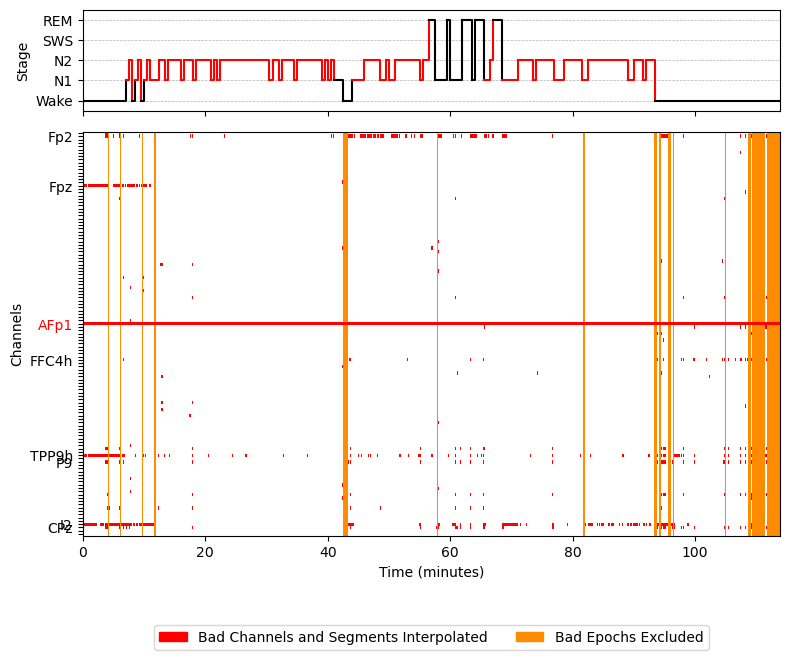

Setting channel interpolation method to ['eeg']: spline.
Computing interpolation matrix from available sensor positions ...
Interpolating 1203 artifacts in 632 epochs ...


In [159]:
# Set default paths and parameters in preprocessing
os.chdir('/Users/theang/Desktop/EMO_PSG_fMRI/data')
raw_file = 'filtered_data/'
processed_file = 'test/'
scoring_file = 'scoring_file/'
montage_temp = 'standard_1005'
interest_stage = ['N2', 'SWS']
online_refer = 'FCz'
rerefer = ['M1', 'M2']
epoch_length = 10

####################################### Automated Preprocessing Pipeline #######################################
file_paths = [os.path.join(raw_file, f) for f in os.listdir(raw_file) if f.endswith(('.vhdr', '.edf', '.fif', '.set', '.fdt', '.bdf', '.cnt', '.gdf', '.nxe', '.eeg', '.mef', '.lay'))]
for file_path in file_paths:
    id = os.path.splitext(os.path.basename(file_path))[0]
    print(f"Start preprocessing for subject {id}.")
    raw = load_raw(file_path)
    raw.set_annotations(None)
    
    raw.get_channel_types()
    chan_types = {
        "M1": "eeg", "M2": "eeg", "I1": "eeg", "I2": "eeg", "EOG1": "eog", 
        "EOG2": "eog", "EMG1": "emg", "EMG2": "emg", "EMG3": "emg", "ECG": "ecg"
    }
    existing_chan = {ch_name: ch_type for ch_name, ch_type in chan_types.items() if ch_name in raw.ch_names}
    raw.set_channel_types(existing_chan)
    if 'FPz' in raw.ch_names:
        raw.rename_channels({'FPz': 'Fpz'})

    # Downsampling and filtering
    raw.resample(sfreq=200)
    raw.notch_filter(freqs=60, method='fir', fir_window='hamming', phase='zero', verbose='ERROR')
    raw.filter(l_freq=0.1, h_freq=35, picks=['eeg', 'eog'], method='fir', fir_window='hamming', phase='zero', verbose='ERROR')
    raw.filter(l_freq=10, h_freq=99.99, picks=['emg'], method='fir', fir_window='hamming', phase='zero', verbose='ERROR')

    # Add online reference channels back
    #raw = mne.add_reference_channels(raw, ref_channels=(online_refer))

    # Set the montage
    montage = mne.channels.make_standard_montage(montage_temp)
    raw.set_montage(montage)

    # Set EEG reference
    raw.set_eeg_reference(ref_channels=(rerefer))

    # Segment raw data into sleep stages
    stage = hypnogram_segment(subject=218, raw=raw)

    # Detect and interpolate artifacts
    ## visual_artifact_inspect(raw)
    auto_artifact_detect_interp(raw, stage=stage, picks=['eeg'], reference=(rerefer),
                                subject_id=id, epoch_length=epoch_length, interest_stage = interest_stage)

    # Apply ICA
    ## apply_ica_to_segments(raw=raw, stage=stage, n_component=0.99,
    ##                   kurt_threshold_z=3, run_ecg=False, auto=True)

    save_path = os.path.join(processed_file, f"{id}.fif")
    raw.save(save_path, overwrite=True)

    raw.plot_psd()
    del raw, stage, id

In [ ]:
# -------- Set Parameters --------- #
subject_id = 990
rerefer = ['M1', 'M2']
picks = 'eeg'
epoch_length = 10
epoch_slide = None

# ----------- Load Data ----------- #
raw = mne.io.read_raw_fif(f'~/Desktop/EMO_PSG_fMRI/data/inspected_data/EMO{subject_id}_N_cfv.fif', preload=True)
raw.set_annotations(None)

# ----- Bad Channel Detection ----- #
raw = badchan_var(raw, picks=picks, reference=rerefer)
raw.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True)

# ------ Artifact Detection ------- #
stage = hypnogram_segment(subject_id, raw)
raw = ptpamp_epoch(raw, threshold=600e-6, epoch_length=epoch_length, epoch_slide=epoch_slide, picks = picks, reference = rerefer)
raw = zscoreamp_epoch_epochwise(raw, stage, threshold_z=5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference = rerefer)
raw = zscoreamp_epoch_chanwise(raw, threshold_z=5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference = rerefer)
raw = flat_epoch(raw, threshold_sd=0.2e-6, min_flat_length=2, window_slide=0.5, epoch_length=epoch_length, epoch_slide=epoch_slide, picks=picks, reference = rerefer)
threshold_badepoch(raw, picks=picks, percent_chan_bad=10)
raw.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True)

# ---- Artifact Interpolation ----- #
raw = raw.interpolate_bads(reset_bads=True, mode='accurate', origin='auto', method='spline', exclude=(), verbose='ERROR')
raw = interpolate_by_epoch(raw, picks=picks, window_ratio=0.05)

# ------------ Run ICA ------------ #
stage_cleaned = hypnogram_segment(subject_id, raw)
raw = apply_ica_to_segments(raw, stage_cleaned, n_component = 0.99, kurt_threshold_z = 3, run_ecg = False)
raw.plot(duration=60.0, scalings=dict(eeg=200e-6), bad_color='red', block=True) ## Check if ICA removed artifacts in bad epochs

# ------- Save cleaned data ------- #
raw.save(f'~/Desktop/EMO_PSG_fMRI/data/preprocessed_data_temporary/EMO{subject_id}_cleaned.fif', overwrite=True)
del raw, stage, stage_cleaned